In [58]:
import recordlinkage
from recordlinkage.datasets import load_febrl4
from recordlinkage.preprocessing import clean
from recordlinkage.index import SortedNeighbourhood
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,roc_curve,plot_roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dfA = pd.read_csv("Data/processed_data.csv",index_col=0)

### Indexing

In [3]:
# The first step in the process is to generate a new dataframe where the multi-index represents all possible 
# pairs of the original dataframes. The dataframes were each 5000 rows in length so we'd expect a full pair index to 
# contain 5,000 x 5,000 = 25,000,000 pairs

In [4]:
indexer = recordlinkage.Index()
indexer.full()
pairs = indexer.index(dfA)

In [5]:
#We can be smarter about our pairing by eliminating pairs that couldn't possibly be from the same individuals. Using
#a technique called blocking we can tell the indexer object to only create pairs that match some criteria.
#in this data-set we have social security ID which is as unique as it gets, but we'll use this as our ground truth, so
#to avoid data leakage will pick less unique identifier, first name.

In [6]:
indexer = recordlinkage.Index()
indexer.block("First_Name")
potential_links = indexer.index(dfA)
len(potential_links)

55357

In [7]:
#We've substantially reduced our number of poten|tial pairs by introducing blocking. We've eliminated 24,995,439
#potential pairs.
print(f'Potential pairs with blocking {len(potential_links)}')
print(f'Pairs eliminated by blocking {len(pairs) - len(potential_links)}')

Potential pairs with blocking 55357
Pairs eliminated by blocking 13718019


In [8]:
#This is where we can bring in some domain knowledge to be more intelligent about blocking. It's very common for customers
#to mispell their name or provide a nick name on some purchases and a full name on others. To better link these instances
#of similar names we can use a sorted neighbors algorythm to group names to then be used for blocking.

In [9]:
indexer = recordlinkage.Index()
indexer.add(SortedNeighbourhood("First_Name",window=3))
potential_links = indexer.index(dfA)
len(potential_links)

86886

In [10]:
#Let's explore how different window sizes change the number of potential links.
#We can see that larger window sizes 
window_range = [1,3,5,7,9]
for window_x in window_range:
    indexer = recordlinkage.Index()
    indexer.add(SortedNeighbourhood("First_Name",window=window_x))
    potential_links = indexer.index(dfA)
    print(f'window size {window_x} creates {len(potential_links)} potential links')

window size 1 creates 55357 potential links
window size 3 creates 86886 potential links
window size 5 creates 121674 potential links
window size 7 creates 153722 potential links
window size 9 creates 188087 potential links


In [11]:
#The process of identified potential pairs using the more discriminating sorted neighborhood process involves three steps
#1.Taking the blocking series for each data frame (in our case "first name") and combining them into one series
#2.Sorting the series
#3.For each element in the series, the function looks within the specified window. 
#If two elements from different series are within the window, they are added to the list of potential pairs.

### Matching

#The compare class and compute methods taken together give you the power to compare your potential links 
#across the dimensions in your data. The process goes like this...
#1. Initialize the the Compare class
#2. Use Compare methods to specify the type of comparision to make for your different features
#3. The compute method uses your comparison methods to create a binary score for potential pairs accross shared dimensions
#1 indicates a match based on the specified criteria. For example, the 'exact' method will compute 1 only if the potential
#pairs share a dimension exactly.

Compare method criteria details

Exact = Compare features of pairs exactly
String 
- The jarowinkler formula compares two strings and assigns a similarity score between 0 and 1 with more similar strings closer to 1. The formula values strings that match from the beggining. If the jarowinkler value is above the threshold, the features will be given a score of 1.
- Without specifying a formula, the strings will be evaluated on the number of matching characters, if the ratio of matching characters to total characters is above the threshold, the features will be given a score of 1.

In [12]:
compare_cl = recordlinkage.Compare()
compare_cl.exact("First_Name", "First_Name", label="First_Name")
compare_cl.string("Last_Name", "Last_Name", method="jarowinkler", threshold=0.85, label="Last_Name")
compare_cl.exact("date_of_birth", "date_of_birth", label="Date_of_Birth")
compare_cl.exact("City", "City", label="city")
compare_cl.exact("Province_Code", "Province_Code", label="State")
compare_cl.string("Address_1", "Address_1", threshold=0.85, label="Address_1")
features = compare_cl.compute(potential_links, dfA)
features

First_Name  Last_Name  Date_of_Birth  city  State  \
rec_id_1     rec_id_2                                                          
rec-857-org  rec-1062-org           0        0.0              0     0      0   
             rec-1821-org           0        0.0              0     0      1   
rec-2463-org rec-1062-org           0        0.0              0     0      0   
             rec-1821-org           0        0.0              0     0      0   
rec-521-org  rec-1062-org           0        0.0              0     0      1   
...                               ...        ...            ...   ...    ...   
rec-5132-org rec-2231-org           0        0.0              0     0      0   
             rec-4952-org           0        0.0              0     0      1   
rec-5148-org rec-2435-org           0        0.0              0     0      0   
             rec-3552-org           0        0.0              0     0      0   
             rec-1709-org           0        0.0              0     0      1   

                           Address_1  
rec_id_1     rec_id_2                 
rec-857-org  rec-1062-org        0.0  
             rec-1821-org        0.0  
rec-2463-org rec-1062-org        0.0  
             rec-1821-org        0.0  
rec-521-org  rec-1062-org        0.0  
...                              ...  
rec-5132-org rec-2231-org        0.0  
             rec-4952-org        0.0  
rec-5148-org rec-2435-org        0.0  
             rec-3552-org        0.0  
             rec-1709-org        0.0  

[188087 rows x 6 columns]

### Evaluate potential pairs

In [13]:
#Now we'll evaluate the potential pairs accross their features and set a threshold of 4 where, a sum of feature scores
#of four or greater will be considered matches. Pairs that sum to less than 4 will be considered different records.

In [14]:
features["Similarity_score"] = features.apply(lambda x:1 if x.sum() >=3 else 0,axis=1)

In [15]:
features[features["Similarity_score"]==1]

,,First_Name,Last_Name,Date_of_Birth,city,State,Address_1,Similarity_score
rec_id_1,rec_id_2,,,,,,,
rec-1153-org,rec-2499-org,0,1.0,0,1,1,0.0,1
rec-5077-org,rec-521-org,1,1.0,1,1,1,1.0,1
rec-5224-org,rec-2994-org,1,1.0,0,1,1,1.0,1
rec-5091-org,rec-1699-org,1,1.0,1,1,1,1.0,1
rec-1490-org,rec-4779-org,1,1.0,0,0,1,0.0,1
...,...,...,...,...,...,...,...,...
rec-4282-org,rec-1537-org,0,1.0,0,1,1,0.0,1
rec-5045-org,rec-1516-org,0,1.0,1,1,1,1.0,1
rec-5066-org,rec-2026-org,0,1.0,1,1,1,1.0,1


### Sanity checks

In [16]:
#Customer ID #rec-5091-org from the index col 1 is a predicted match with #rec-1699-org
#This user should have every factor in common given the 1s scored in the matches
#These users are in fact exactly the same!

In [17]:
dfA.loc["rec-5091-org"]

First_Name                 kate
Last_Name                brocke
Street_Number                12
Address_1        kareelah vista
Address_2             pine hill
City                   yaroomba
Zip                        4740
Province_Code               vic
date_of_birth       1.91307e+07
Shopify_ID              2213154
Name: rec-5091-org, dtype: object

In [18]:
dfA.loc["rec-1699-org"]

First_Name                 kate
Last_Name                 brock
Street_Number                12
Address_1        kareelah vista
Address_2             pine hill
City                   yaroomba
Zip                        4740
Province_Code               vic
date_of_birth       1.91307e+07
Shopify_ID              2213154
Name: rec-1699-org, dtype: object

### Scoring

In [19]:
#This is a binary classification problem with two options, match or no-match. We've already established our prediction column, 
#now we need our ground truth column. Using the truth and prediction columns, we can get our f1, accuracy, and precision scores.

In [20]:
#Join our potential pair file with our original data set to get the actual Shopify IDs for the customers in our multi-index 1
features_merge = pd.merge(left=features,right=dfA[["Shopify_ID"]],how='left',left_on="rec_id_1",right_on="rec_id",right_index=True)
mapper_A = {"Shopify_ID":"Shopify_ID_A"}
features_merge.rename(columns=mapper_A)

First_Name  Last_Name  Date_of_Birth  city  State  \
rec_id_1     rec_id_2                                                          
rec-857-org  rec-1062-org           0        0.0              0     0      0   
             rec-1821-org           0        0.0              0     0      1   
rec-2463-org rec-1062-org           0        0.0              0     0      0   
             rec-1821-org           0        0.0              0     0      0   
rec-521-org  rec-1062-org           0        0.0              0     0      1   
...                               ...        ...            ...   ...    ...   
rec-5132-org rec-2231-org           0        0.0              0     0      0   
             rec-4952-org           0        0.0              0     0      1   
rec-5148-org rec-2435-org           0        0.0              0     0      0   
             rec-3552-org           0        0.0              0     0      0   
             rec-1709-org           0        0.0              0     0      1   

                           Address_1  Similarity_score  Shopify_ID_A  
rec_id_1     rec_id_2                                                 
rec-857-org  rec-1062-org        0.0                 0       3489916  
             rec-1821-org        0.0                 0       3489916  
rec-2463-org rec-1062-org        0.0                 0       9329570  
             rec-1821-org        0.0                 0       9329570  
rec-521-org  rec-1062-org        0.0                 0       8144739  
...                              ...               ...           ...  
rec-5132-org rec-2231-org        0.0                 0       2492474  
             rec-4952-org        0.0                 0       2492474  
rec-5148-org rec-2435-org        0.0                 0       2472793  
             rec-3552-org        0.0                 0       2472793  
             rec-1709-org        0.0                 0       2472793  

[188087 rows x 8 columns]

In [21]:
#Join our potential pair file with our original data set to get the actual Shopify IDs for the customers in our multi-index 2
features_merge = pd.merge(left=features_merge,right=dfA[["Shopify_ID"]],how='left',left_on="rec_id_2",right_on="rec_id",right_index=True)
mapper_B = {"Shopify_ID":"Shopify_ID_B"}
features_merge.rename(columns=mapper_B)

First_Name  Last_Name  Date_of_Birth  city  State  \
rec_id_1     rec_id_2                                                          
rec-857-org  rec-1062-org           0        0.0              0     0      0   
             rec-1821-org           0        0.0              0     0      1   
rec-2463-org rec-1062-org           0        0.0              0     0      0   
             rec-1821-org           0        0.0              0     0      0   
rec-521-org  rec-1062-org           0        0.0              0     0      1   
...                               ...        ...            ...   ...    ...   
rec-5132-org rec-2231-org           0        0.0              0     0      0   
             rec-4952-org           0        0.0              0     0      1   
rec-5148-org rec-2435-org           0        0.0              0     0      0   
             rec-3552-org           0        0.0              0     0      0   
             rec-1709-org           0        0.0              0     0      1   

                           Address_1  Similarity_score  Shopify_ID_x  \
rec_id_1     rec_id_2                                                  
rec-857-org  rec-1062-org        0.0                 0       3489916   
             rec-1821-org        0.0                 0       3489916   
rec-2463-org rec-1062-org        0.0                 0       9329570   
             rec-1821-org        0.0                 0       9329570   
rec-521-org  rec-1062-org        0.0                 0       8144739   
...                              ...               ...           ...   
rec-5132-org rec-2231-org        0.0                 0       2492474   
             rec-4952-org        0.0                 0       2492474   
rec-5148-org rec-2435-org        0.0                 0       2472793   
             rec-3552-org        0.0                 0       2472793   
             rec-1709-org        0.0                 0       2472793   

                           Shopify_ID_y  
rec_id_1     rec_id_2                    
rec-857-org  rec-1062-org       6503115  
             rec-1821-org       8721689  
rec-2463-org rec-1062-org       6503115  
             rec-1821-org       8721689  
rec-521-org  rec-1062-org       6503115  
...                                 ...  
rec-5132-org rec-2231-org       7883652  
             rec-4952-org       4293980  
rec-5148-org rec-2435-org       5873915  
             rec-3552-org       7533159  
             rec-1709-org       9581654  

[188087 rows x 9 columns]

In [22]:
features_merge[features_merge["Similarity_score"]==1]

,,First_Name,Last_Name,Date_of_Birth,city,State,Address_1,Similarity_score,Shopify_ID_x,Shopify_ID_y
rec_id_1,rec_id_2,,,,,,,,,
rec-1153-org,rec-2499-org,0,1.0,0,1,1,0.0,1,8900010,4889678
rec-5077-org,rec-521-org,1,1.0,1,1,1,1.0,1,8144739,8144739
rec-5224-org,rec-2994-org,1,1.0,0,1,1,1.0,1,3242408,3242408
rec-5091-org,rec-1699-org,1,1.0,1,1,1,1.0,1,2213154,2213154
rec-1490-org,rec-4779-org,1,1.0,0,0,1,0.0,1,9425976,5268631
...,...,...,...,...,...,...,...,...,...,...
rec-4282-org,rec-1537-org,0,1.0,0,1,1,0.0,1,7131922,8870856
rec-5045-org,rec-1516-org,0,1.0,1,1,1,1.0,1,1744778,1744778
rec-5066-org,rec-2026-org,0,1.0,1,1,1,1.0,1,9201028,9201028


In [23]:
#Now we'll compare our two columns of Shopify IDs, where they match we'll indicate 1 for an actual match. When they
#don't match we'll mark down 0.
features_merge["Actual_similarity_score"] = features_merge.apply(lambda x:1 if x["Shopify_ID_x"] == x["Shopify_ID_y"] else 0,axis=1)

In [24]:
print(f'f1 score {f1_score(y_pred=features_merge["Similarity_score"],y_true=features_merge["Actual_similarity_score"])}')
print(f'accuracy score {accuracy_score(y_pred=features_merge["Similarity_score"],y_true=features_merge["Actual_similarity_score"])}')
print(f'precision score {precision_score(y_pred=features_merge["Similarity_score"],y_true=features_merge["Actual_similarity_score"])}')

f1 score 0.8566308243727598
accuracy score 0.9995746649157039
precision score 0.7492163009404389


In [25]:
features_merge[features_merge["Actual_similarity_score"] != features_merge["Similarity_score"]]

,,First_Name,Last_Name,Date_of_Birth,city,State,Address_1,Similarity_score,Shopify_ID_x,Shopify_ID_y,Actual_similarity_score
rec_id_1,rec_id_2,,,,,,,,,,
rec-1153-org,rec-2499-org,0,1.0,0,1,1,0.0,1,8900010,4889678,0
rec-1490-org,rec-4779-org,1,1.0,0,0,1,0.0,1,9425976,5268631,0
rec-2215-org,rec-1725-org,1,0.0,0,1,1,0.0,1,7115051,6838887,0
rec-3951-org,rec-4951-org,1,1.0,0,0,1,0.0,1,8311385,4899443,0
rec-2286-org,rec-394-org,1,1.0,0,0,1,0.0,1,9772701,7284475,0
...,...,...,...,...,...,...,...,...,...,...,...
rec-3522-org,rec-3149-org,1,0.0,0,1,1,0.0,1,4393661,9831162,0
rec-1286-org,rec-1503-org,1,1.0,0,0,1,0.0,1,4721073,7987659,0
rec-4749-org,rec-838-org,1,1.0,0,0,1,0.0,1,8656075,7928114,0


In [27]:
#threshold_values = [3,4,5,6]
#for values in threshold_values:
 #   filtered_score_df = features_merge[features_merge["Similarity_sum"] >= values]
  #  print(f'f1 score {values} {f1_score(y_pred=filtered_score_df["Similarity_score"],y_true=filtered_score_df["Actual_similarity_score"])}')
   # print(f'accuracy score {values} {accuracy_score(y_pred=filtered_score_df["Similarity_score"],y_true=filtered_score_df["Actual_similarity_score"])}')
    #print(f'precision score {values} {precision_score(y_pred=filtered_score_df["Similarity_score"],y_true=filtered_score_df["Actual_similarity_score"])}')
#    print("")

f1 score 3 0.8566308243727598
accuracy score 3 0.7492163009404389
precision score 3 0.7492163009404389

f1 score 4 1.0
accuracy score 4 1.0
precision score 4 1.0

f1 score 5 1.0
accuracy score 5 1.0
precision score 5 1.0

f1 score 6 1.0
accuracy score 6 1.0
precision score 6 1.0



In [ ]:
#features_merge["Similarity_sum"] = features_merge["First_Name"] + features_merge["Last_Name"] + features_merge["Date_of_Birth"]+features_merge["city"]+features_merge["State"]+features_merge["Address_1"]

In [49]:
threshold_values = [3,4,5,6]
features_to_sum = ["First_Name","Last_Name","Date_of_Birth","city","State","Address_1"]
p_r_curve = {}
for values in threshold_values:
    features_merge["Similarity_score"] = features_merge.apply(lambda x:1 if x[features_to_sum].sum() >=values else 0,axis=1)
    print(f'f1 score ({values}) {f1_score(y_pred=features_merge["Similarity_score"],y_true=features_merge["Actual_similarity_score"])}')
    print(f'accuracy score ({values}) {accuracy_score(y_pred=features_merge["Similarity_score"],y_true=features_merge["Actual_similarity_score"])}')
    print(f'precision score ({values}) {precision_score(y_pred=features_merge["Similarity_score"],y_true=features_merge["Actual_similarity_score"])}')
    print(f'recall score ({values}) {recall_score(y_pred=features_merge["Similarity_score"],y_true=features_merge["Actual_similarity_score"])}')
    print("")
    p_r_curve[values] = [precision_score(y_pred=features_merge["Similarity_score"],y_true=features_merge["Actual_similarity_score"]),recall_score(y_pred=features_merge["Similarity_score"],y_true=features_merge["Actual_similarity_score"])]

f1 score (3) 0.8566308243727598
accuracy score (3) 0.9995746649157039
precision score (3) 0.7492163009404389
recall score (3) 1.0

f1 score (4) 0.9979035639412999
accuracy score (4) 0.9999946833114463
precision score (4) 1.0
recall score (4) 0.99581589958159

f1 score (5) 0.9936842105263157
accuracy score (5) 0.9999840499343389
precision score (5) 1.0
recall score (5) 0.9874476987447699

f1 score (6) 0.8960739030023095
accuracy score (6) 0.9997607490150835
precision score (6) 1.0
recall score (6) 0.8117154811715481



In [76]:
p_r_curve_df = pd.DataFrame(data=p_r_curve)

In [77]:
p_r_curve_df = p_r_curve_df.rename(index={0:"Precision",1:"Recall"})
p_r_curve_df = p_r_curve_df.transpose()
p_r_curve_df

,Precision,Recall
3,0.749216,1.000000
4,1.000000,0.995816
5,1.000000,0.987448
6,1.000000,0.811715


In [78]:
p_r_curve_df = p_r_curve_df.reset_index()
p_r_curve_df = p_r_curve_df.rename(columns={"index":"Threshhold"})
p_r_curve_df

,Threshhold,Precision,Recall
0,3,0.749216,1.000000
1,4,1.000000,0.995816
2,5,1.000000,0.987448
3,6,1.000000,0.811715


In [84]:
p_r_curve_df.loc[0]["Recall"]

Threshhold    3.000000
Precision     0.749216
Recall        1.000000
Name: 0, dtype: float64

''

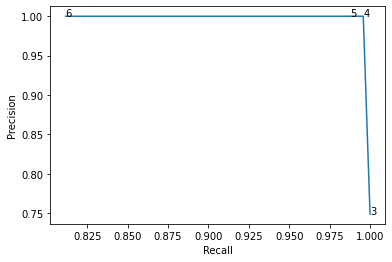

In [88]:
fig, ax = plt.subplots()
sns.lineplot(data=p_r_curve_df,x="Recall",y="Precision",markers=True)
ax.annotate("3",(p_r_curve_df.loc[0]["Recall"],p_r_curve_df.loc[0]["Precision"]))
ax.annotate("4",(p_r_curve_df.loc[1]["Recall"],p_r_curve_df.loc[1]["Precision"]))
ax.annotate("5",(p_r_curve_df.loc[2]["Recall"],p_r_curve_df.loc[2]["Precision"]))
ax.annotate("6",(p_r_curve_df.loc[3]["Recall"],p_r_curve_df.loc[3]["Precision"]))
;